In [ ]:
#Installing the package
!pip install bertopic
!pip install octis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
#%cd <--The-Code-Folder-->
!pwd

#Preparing The Dataset

In [ ]:
import re
import nltk
import string
import pandas as pd

from typing import List, Tuple, Union
from octis.dataset.dataset import Dataset
from octis.preprocessing.preprocessing import Preprocessing

def DS_Preprocessing(Cyberattack_dataset_str: str, DS_label=''):
  TweetsCloumn= "text"
  closName= [ '_id',  'annotation',  'date',  'id',  'relevant',  'text',  'tweet.contributors',  'tweet.coordinates',  'tweet.created_at',
              'tweet.display_text_range',  'tweet.entities',  'tweet.extended_entities',  'tweet.extended_tweet',  'tweet.favorite_count',
              'tweet.favorited',  'tweet.filter_level',  'tweet.geo',  'tweet.id',  'tweet.id_str',  'tweet.in_reply_to_screen_name',
              'tweet.in_reply_to_status_id',  'tweet.in_reply_to_status_id_str',  'tweet.in_reply_to_user_id',  'tweet.in_reply_to_user_id_str',
              'tweet.is_quote_status',  'tweet.lang',  'tweet.place',  'tweet.possibly_sensitive',  'tweet.quote_count',  'tweet.quoted_status',
              'tweet.quoted_status_id',  'tweet.quoted_status_id_str',  'tweet.quoted_status_permalink',  'tweet.reply_count',  'tweet.retweet_count',
              'tweet.retweeted',  'tweet.source',  'tweet.text',  'tweet.timestamp_ms',  'tweet.truncated',
                'tweet.user',  'type',  'watson.categories',  'watson.entities',  'watson.language',  'watson.usage']
  Cyberattack_dataset = pd.read_csv(Cyberattack_dataset_str+".csv",sep=',',usecols=closName,lineterminator='\n')
  Cyberattack_dataset[TweetsCloumn]=Cyberattack_dataset[TweetsCloumn].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ',regex=True)
  Cyberattack_dataset[TweetsCloumn]=Cyberattack_dataset[TweetsCloumn].str.replace("[\[\]\(\)\|\"\'#@/:%.,_-]", " ",regex=True, flags=re.UNICODE)
  Cyberattack_dataset[TweetsCloumn] = Cyberattack_dataset[TweetsCloumn].str.encode('ascii', 'ignore').str.decode('ascii')
  Cyberattack_dataset = Cyberattack_dataset.replace(r'\n',' ', regex=True)
  Cyberattack_dataset[TweetsCloumn] = Cyberattack_dataset[TweetsCloumn].replace('\n','', regex=True)
  Cyberattack_dataset[TweetsCloumn] = Cyberattack_dataset[TweetsCloumn].str.lower()
  Cyberattack_dataset = Cyberattack_dataset.loc[ (Cyberattack_dataset[TweetsCloumn].values != ""), :]
  Cyberattack_dataset['type'] = Cyberattack_dataset['type'].str.replace("[\"\[\]]", " ",regex=True)
  Cyberattack_dataset['type']= Cyberattack_dataset["type"].str.strip()
  Cyberattack_dataset = Cyberattack_dataset[Cyberattack_dataset['type'].isin(["ddos", "leak", "ransomware","0day","botnet","vulnerability"])]
  #print(Cyberattack_dataset['type'].value_counts())
  if DS_label != 'all':
    Cyberattack_dataset['type'] = Cyberattack_dataset.apply(lambda row: row['type'] if row['type'] ==DS_label else 'Not', axis=1)
  #print(Cyberattack_dataset['type'].value_counts())
  Cyberattack_dataset_docs = Cyberattack_dataset[TweetsCloumn].to_list()
  Cyberattack_dataset_docs = [doc.lower().replace("\n", " ") for doc in Cyberattack_dataset_docs if len(doc) > 2]
  #----creating the dataset in text format as required in OCTIS----
  with open(str(Cyberattack_dataset_str)+".txt", mode="wt", encoding="utf-8") as ds_txtfile:
      ds_txtfile.write("\n".join(Cyberattack_dataset_docs))
  #----creating the label file to pass it to OCTIS functions----
  with open(str(Cyberattack_dataset_str) +"_labels_"+ str(DS_label) + ".txt", 'a') as f:
    dfAsString = '\n'.join(Cyberattack_dataset['type'].astype(str).values)
    f.write(dfAsString)


def GetOctisDS(Cyberattack_dataset_str: str,labellingType: str):
  data = Dataset()
  DS_Preprocessing(Cyberattack_dataset_str,DS_label=labellingType)
  preprocessor = Preprocessing(lowercase=False,remove_punctuation=False,punctuation=string.punctuation,remove_numbers=False,lemmatize=False,language="english",
                            split=True, verbose=True,save_original_indexes=True,remove_stopwords_spacy=False)
  documents_path = Cyberattack_dataset_str+ '.txt'
  label_path= str(Cyberattack_dataset_str) +"_labels_"+ str(labellingType) + ".txt"
  ds= preprocessor.preprocess_dataset(documents_path=documents_path, labels_path=label_path)
  ds.save(Cyberattack_dataset_str)
  return ds

#%%capture
from sentence_transformers import SentenceTransformer

# Prepare the embeddings
Cybertweets_ds= GetOctisDS('cybertweets', '')
train_corpus, test_corpus = Cybertweets_ds.get_partitioned_corpus(use_validation=False)
train_corpus = [" ".join(words) for words in train_corpus]
test_corpus = [" ".join(words) for words in test_corpus]
Sentencemodel = SentenceTransformer("all-mpnet-base-v2")
train_embeddings = Sentencemodel.encode(train_corpus, show_progress_bar=True)
test_embeddings = Sentencemodel.encode(test_corpus, show_progress_bar=True)

#Urgency Sentiment  (UrgentFocus)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from scipy import sparse
import re
from sklearn.pipeline import Pipeline
import numpy as np
import copy
import json
from numbers import Integral
from spacy.lang.en import English
!pip install vaderSentiment
import nltk
nltk.download('stopwords')
nltk.download("punkt")
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Reading the CyberAttack Keywords to update the sentiment lexicon
with open('CyberAttackKeywords.txt') as f:
  cyber_words = dict((x.strip(),-5) for x in f)
SIA = SentimentIntensityAnalyzer()
SIA.lexicon.update(cyber_words)


#extending The CountVectorizer class to include the cybersecurity sentiment
class UrgentFocus_CountVectorizer(CountVectorizer):
    def __init__(self, input='content', encoding='utf-8', decode_error='strict',
                 strip_accents=None, lowercase=False, preprocessor=None, tokenizer=None, stop_words=None,
                 token_pattern=r"(?u)\b\w\w+\b", ngram_range=(1, 1), analyzer='word',
                 max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False,
                 dtype=np.int64):
     super().__init__(input=input, encoding=encoding, decode_error=decode_error, strip_accents=strip_accents,
                      lowercase=lowercase, preprocessor=preprocessor, tokenizer=tokenizer, stop_words=stop_words,
                      token_pattern=token_pattern, ngram_range=ngram_range, analyzer=analyzer, max_df=max_df,
                      min_df=min_df, max_features=max_features, vocabulary=vocabulary, binary=binary, dtype=dtype)
    def set_params(self, **parameters):
      for parameter, value in parameters.items():
        setattr(self, parameter, value)
      return self
    def get_params(self, deep=True):
      return {"input":self.input, "encoding":self.encoding, "decode_error":self.decode_error, "strip_accents":self.strip_accents,
                      "lowercase":self.lowercase, "preprocessor":self.preprocessor, "tokenizer":self.tokenizer, "stop_words":self.stop_words,
                      "token_pattern":self.token_pattern, "ngram_range":self.ngram_range, "analyzer":self.analyzer, "max_df":self.max_df,
                      "min_df":self.min_df, "max_features":self.max_features, "vocabulary":self.vocabulary, "binary":self.binary, "dtype":self.dtype}

    def transform(self, raw_documents):
      X = super().transform(raw_documents)
      adjusted_matrix = X.toarray()
      for i, doc in enumerate(raw_documents):
        score = SIA.polarity_scores(doc)
        if (score['compound'] < 0): #and (count>0):
          adjusted_matrix[i] *= 2
      return sparse.csr_matrix(adjusted_matrix)

    def fit_transform(self, raw_documents, y=None):
      X = super().fit_transform(raw_documents)
      adjusted_matrix = X.toarray()
      for i, doc in enumerate(raw_documents):
        score = SIA.polarity_scores(doc)
        if (score['compound'] < 0): #and (count>0):
          adjusted_matrix[i] *= 2
      return sparse.csr_matrix(adjusted_matrix)

#Training (train_topic_model) and evalutating (evaluate_topic_model_Quality) functions for Topic Modelling algorithms

In [ ]:
# adapted from https://github.com/MaartenGr/BERTopic_evaluation
from octis.models.ETM import ETM
from octis.models.LDA import LDA
from octis.models.NMF import NMF
from octis.models.CTM import CTM
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity,KLDivergence,InvertedRBO
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.classification_metrics import F1Score, PrecisionScore, RecallScore, AccuracyScore, ClassificationScore
import json
import time
import itertools
import numpy as np
import pandas as pd
import nltk
from typing import Mapping, Any, List, Tuple
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer



def train_topic_model(TMType: str, Cyberattack_dataset_str: str, params: Mapping[str, any], labellingClass:str,TopicNo):
  ##----Preparing the data and creating the OCTIS dataset
  train_topic_model.params= params
  currentDS= GetOctisDS(Cyberattack_dataset_str, labellingClass)
  ##----- training BERTopic UBERTopic models
  if (TMType == "BERTopic") or (TMType =="UBERTopic"):
    model = BERTopic(**params)
    start = time.time()
    train_corpus, test_corpus = Cybertweets_ds.get_partitioned_corpus(use_validation=False)
    train_corpus = [" ".join(words) for words in train_corpus]
    test_corpus = [" ".join(words) for words in test_corpus]
    topics, probs = model.fit_transform(train_corpus, train_embeddings)#train_corpus
    train_topic_model.prob = probs
    train_topic_model.topic = topics
    train_topic_model.topicss = topics
    train_topic_model.topic_word_matrix =model.c_tf_idf_.toarray()
    train_topic_model.topic_document_matrix =  np.array(probs).transpose()
    topic_word_matrix =model.c_tf_idf_.toarray()
    topic_document_matrix =  np.array(probs).transpose()
    test_topics, test_probs = model.transform(test_corpus, test_embeddings)
    test_topic_document_matrix = np.array(test_probs).transpose()
    train_corpus, test_corpus = currentDS.get_partitioned_corpus(use_validation=False)
    all_words = [word for words in train_corpus for word in words] #train_corpus self.data.get_corpus()
    bertopic_topics = [
            [
                vals[0] if vals[0] in all_words else all_words[0]
                for vals in model.get_topic(i)[:10]
            ]
            for i in range(len(set(topics)) - 1)
        ]
    train_topic_model.bertopic_topics = bertopic_topics
    train_topic_model.topic_word_matrix = topic_word_matrix
    output_tm = {"topics": bertopic_topics,
                      "topic-word-matrix":topic_word_matrix,
                      "topic-document-matrix": topic_document_matrix,
                      "test-topic-document-matrix": test_topic_document_matrix}
    end = time.time()
    computation_time = end - start
  ##----training other Models : CTM and LDA
  elif TMType == "LDA":
    model = LDA(**params)
    start = time.time()
    output_tm = model.train_model(currentDS)
    end = time.time()
    computation_time = end - start
  elif TMType == "CTM":
    model = CTM(**params)
    start = time.time()
    output_tm = model.train_model(currentDS)
    end = time.time()
    computation_time = end - start

  ##----Computing the classification Accuracy
  F1_Score = F1Score(dataset= currentDS,average='weighted')
  F1_ScoreScore= F1_Score.score(output_tm)
  Precision_Score= PrecisionScore(dataset= currentDS,average='weighted')
  Precision_ScoreScore= Precision_Score.score(output_tm)
  Recall_Score = RecallScore(dataset= currentDS,average='weighted')
  Recall_ScoreScore= Recall_Score.score(output_tm)
  Accuracy_Score = AccuracyScore(dataset= currentDS,average='weighted')
  Accuracy_ScoreScore= Accuracy_Score.score(output_tm)
  Classification_score = ClassificationScore(currentDS, average='weighted')
  y_true, y_pred = Classification_score.score(output_tm)
  from sklearn.metrics import classification_report
  Acc_classesReport = classification_report(y_true, y_pred, output_dict=True)
  Acc_classesReport_df = pd.DataFrame(Acc_classesReport).transpose()


  colsName = ["Dataset", "Dataset_Size", "Model","labellingType","NumberOfTopic",
              "Computation_Time","Acc_classesReport","F1_ScoreScore","Precision_ScoreScore",
              "Recall_ScoreScore","Accuracy_ScoreScore"]
  resultsDS=pd.read_csv('AccuracyResult.csv',sep=',',usecols=colsName)
  NewRow= {'Dataset': Cyberattack_dataset_str, 'Dataset_Size': len(currentDS.get_corpus()), 'Model': TMType,'labellingType':labellingClass, 'NumberOfTopic':TopicNo,
             'Computation_Time':computation_time,'Acc_classesReport':Acc_classesReport_df.to_numpy(),
           'F1_ScoreScore':float(F1_ScoreScore),'Precision_ScoreScore':float(Precision_ScoreScore),
           'Recall_ScoreScore':float(Recall_ScoreScore),'Accuracy_ScoreScore':float(Accuracy_ScoreScore)}
  resultsDS.loc[len(resultsDS)] = NewRow
  resultsDS.to_csv('AccuracyResult.csv',sep=',',index=False)

def evaluate_topic_model_Quality(TMType: str, Cyberattack_dataset_str: str, params: Mapping[str, any],TopicNo=0):

  train_topic_model.params= params
  # Prepare docs
  currentDS = Cybertweets_ds
  if (TMType == "BERTopic") or (TMType =="UBERTopic"):
    model = BERTopic(**params)
    start = time.time()
    train_corpus, test_corpus = Cybertweets_ds.get_partitioned_corpus(use_validation=False)
    train_corpus = [" ".join(words) for words in train_corpus]
    test_corpus = [" ".join(words) for words in test_corpus]
    topics, probs = model.fit_transform(train_corpus, train_embeddings)#train_corpus
    train_topic_model.prob = probs
    train_topic_model.topic = topics
    train_topic_model.topicss = topics
    train_topic_model.topic_word_matrix =model.c_tf_idf_.toarray()
    train_topic_model.topic_document_matrix =  np.array(probs).transpose()
    topic_word_matrix =model.c_tf_idf_.toarray()
    topic_document_matrix =  np.array(probs).transpose()
    test_topics, test_probs = model.transform(test_corpus, test_embeddings)
    test_topic_document_matrix = np.array(test_probs).transpose()
    train_corpus, test_corpus = currentDS.get_partitioned_corpus(use_validation=False)
    all_words = [word for words in train_corpus for word in words] #train_corpus self.data.get_corpus()
    bertopic_topics = [
            [
                vals[0] if vals[0] in all_words else all_words[0]
                for vals in model.get_topic(i)[:10]
            ]
            for i in range(len(set(topics)) - 1)
        ]
    train_topic_model.bertopic_topics = bertopic_topics
    train_topic_model.topic_word_matrix = topic_word_matrix
    output_tm = {"topics": bertopic_topics,
                      "topic-word-matrix":topic_word_matrix,
                      "topic-document-matrix": topic_document_matrix,
                      "test-topic-document-matrix": test_topic_document_matrix}
    end = time.time()
    computation_time = end - start
  elif TMType == "LDA":
    model = LDA(**params)
    start = time.time()
    output_tm = model.train_model(currentDS)
    end = time.time()
    computation_time = end - start
  elif TMType == "CTM":
    model = CTM(**params)
    start = time.time()
    output_tm = model.train_model(currentDS)
    end = time.time()
    computation_time = end - start

  npmi = Coherence(texts=currentDS.get_corpus(), topk=10, measure="c_npmi")
  npmiScore= npmi.score(output_tm)
  coherenceCv = Coherence(texts=currentDS.get_corpus(), topk=10, measure="c_v")
  coherenceCvScore= coherenceCv.score(output_tm)
  topic_diversity = TopicDiversity(topk=10)
  topic_diversityScore= topic_diversity.score(output_tm)

  colsName = ["Dataset", "Dataset_Size", "Model","labellingType","NumberOfTopic",
              "Computation_Time","AddedTime","npmiScore","coherenceCvScore","topic_diversityScore","TopicQuality"]
  resultsDS=pd.read_csv('TQresults2.csv',sep=',',usecols=colsName)
  NewRow= {'Dataset': Cyberattack_dataset_str, 'Dataset_Size': len(currentDS.get_corpus()), 'Model': TMType, 'labellingType':'-', 'NumberOfTopic':TopNo,
             'Computation_Time':computation_time,'AddedTime':'','npmiScore':float(npmiScore),
             'coherenceCvScore':float(coherenceCvScore),'topic_diversityScore':float(topic_diversityScore),'TopicQuality':float(topic_diversityScore)*float(coherenceCvScore) }
  resultsDS.loc[len(resultsDS)] = NewRow
  #NewresultsDS = pd.concat([resultsDS,pd.DataFrame(NewRow)], ignore_index = True)
  resultsDS.to_csv('TQresults.csv',sep=',',index=False)



#The training and evalution instances for the four Topic Modelling algorithms (UBERTopic, BERTopic , CTM, LDA) using *Cybersecurity X Dataset 2018*

In [ ]:
##BERTopic
def TP_evalution(TopNo):
  for i, AttackClass in enumerate([ "0day","vulnerability", "botnet","leak","ddos","ransomware"]):
    params = {
        "embedding_model": "all-mpnet-base-v2", #all-mpnet-base-v2
        "nr_topics": TopNo,
        "verbose": True,
        "calculate_probabilities": True,}
    train_topic_model(TMType="BERTopic",Cyberattack_dataset_str="cybertweets",params=params,labellingClass=AttackClass,TopicNo=TopNo)
  evaluate_topic_model_Quality(TMType="BERTopic",Cyberattack_dataset_str="cybertweets",params=params,TopicNo=TopNo)

for TopNo in range(20,160,10):
  TP_evalution(TopNo)



In [ ]:
##UBERTopic
from transformers import BertTokenizer, BertForMaskedLM
tokenizer = BertTokenizer.from_pretrained("../CyBERTBaseMLMv1_1")
representation_model = BertForMaskedLM.from_pretrained("../CyBERTBaseMLMv1_1")


def TP_evalution(TopNo):
  for i, AttackClass in enumerate([ "0day", "botnet","leak","ddos","ransomware","vulnerability"]): #
    params = {
        "embedding_model": "all-mpnet-base-v2", #all-mpnet-base-v2
        "nr_topics": TopNo,
        "verbose": True,
         "vectorizer_model":UrgentFocus_CountVectorizer(stop_words="english"),
        "representation_model":representation_model,
        "calculate_probabilities": True,}
    train_topic_model(TMType="UBERTopic",Cyberattack_dataset_str="cybertweets",params=params,labellingClass=AttackClass,TopicNo=TopNo)
  evaluate_topic_model_Quality(TMType="UBERTopic",Cyberattack_dataset_str="cybertweets",params=params,TopicNo=TopNo)

for TopNo in range(20,160,10):
  TP_evalution(TopNo)

In [ ]:
##CTM
def TP_evalution(TopNo):
  for i, AttackClass in enumerate([ "0day", "botnet","leak","ddos","ransomware","vulnerability"]):
   params = {"num_topics": TopNo,"model_type":"LDA","inference_type":"combined"}
   train_topic_model(TMType="CTM",Cyberattack_dataset_str="cybertweets",params=params,labellingClass=AttackClass,TopicNo=TopNo)
  evaluate_topic_model_Quality(TMType="CTM",Cyberattack_dataset_str="cybertweets",params=params,TopicNo=TopNo)

for TopNo in range(20,160,10):
  TP_evalution(TopNo)

In [ ]:
##LDA
def TP_evalution(TopNo):
  for i, AttackClass in enumerate([ "0day", "botnet","leak","ddos","ransomware","vulnerability"]):
   params = {"num_topics": TopNo}
   train_topic_model(TMType="LDA",Cyberattack_dataset_str="cybertweets",params=params,labellingClass=AttackClass,TopicNo=TopNo)


for TopNo in range(20,160,10):
  TP_evalution(TopNo)

#Showing The Results

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from typing import Mapping, List
Q_colsName = ["Dataset", "Dataset_Size", "Model","labellingType","NumberOfTopic",
              "Computation_Time","AddedTime","npmiScore","coherenceCvScore","topic_diversityScore","TopicQuality"]
Q_resultsDS=pd.read_csv('TQresults.csv',sep=',',usecols=Q_colsName)
Q_Roundcols = ['npmiScore', 'coherenceCvScore','topic_diversityScore','TopicQuality']
Q_resultsDS[Q_Roundcols] = Q_resultsDS[Q_Roundcols].round(2)
display(Q_resultsDS[['Model','npmiScore','coherenceCvScore','topic_diversityScore','TopicQuality','NumberOfTopic','Dataset']])

/content/drive/My Drive/PhD/FirstPaper/Final/ForGithub


,Model,npmiScore,coherenceCvScore,topic_diversityScore,TopicQuality,NumberOfTopic,Dataset
0,BERTopic,0.23,0.65,0.85,0.56,20,cybertweets
1,BERTopic,0.24,0.65,0.88,0.57,30,cybertweets
2,BERTopic,0.20,0.60,0.90,0.54,40,cybertweets
3,BERTopic,0.21,0.61,0.86,0.53,50,cybertweets
4,BERTopic,0.21,0.60,0.87,0.52,60,cybertweets
5,BERTopic,0.22,0.62,0.88,0.54,70,cybertweets
6,BERTopic,0.24,0.66,0.87,0.58,80,cybertweets
7,BERTopic,0.22,0.63,0.87,0.55,90,cybertweets
8,BERTopic,0.22,0.62,0.87,0.53,100,cybertweets
9,BERTopic,0.22,0.62,0.86,0.54,110,cybertweets


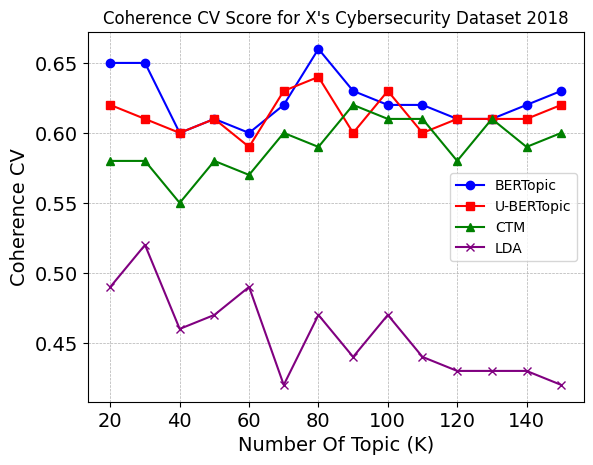

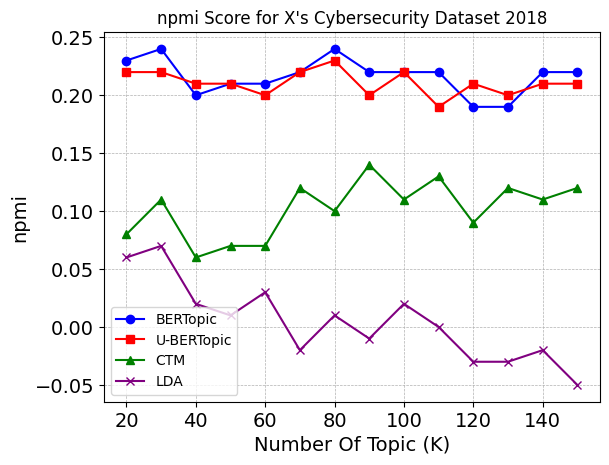

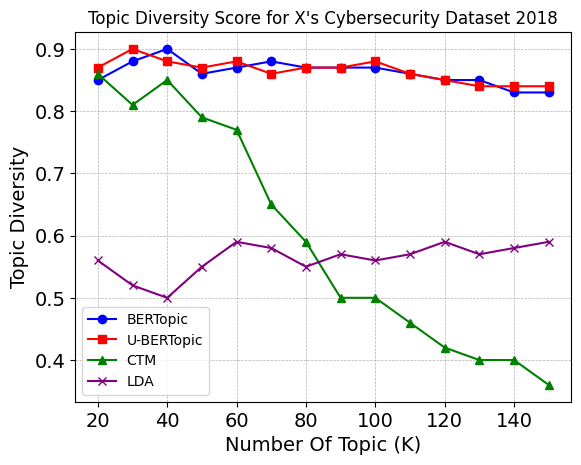

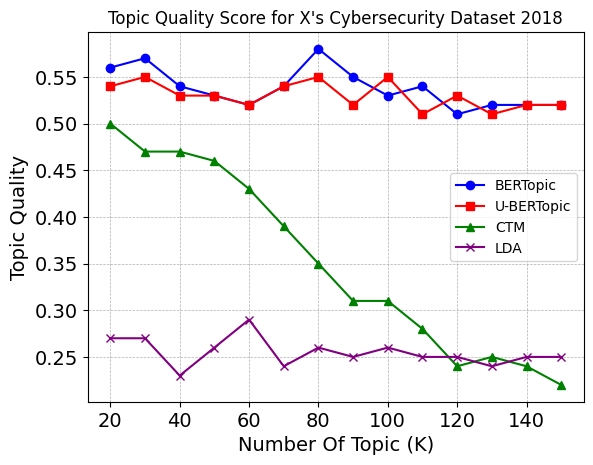

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# X-axis: Number of Topics (K)
K = range(20,160,10)

BERTopic_ds = Q_resultsDS[(Q_resultsDS["Model"] == "BERTopic")]
ZTopic_ds = Q_resultsDS[(Q_resultsDS["Model"] == "UBERTopic")]
CTM_ds = Q_resultsDS[(Q_resultsDS["Model"] == "CTM")]
LDA_ds = Q_resultsDS[(Q_resultsDS["Model"] == "LDA")]

# Plotting the lines
Metrics = ['Coherence CV', 'npmi','Topic Diversity','Topic Quality']
for i, Metric in enumerate([ "coherenceCvScore", "npmiScore","topic_diversityScore","TopicQuality"]):
  plt.plot(K, BERTopic_ds[Metric], label='BERTopic', color='blue',marker='o', linestyle='-')
  plt.plot(K, ZTopic_ds[Metric], label='U-BERTopic', color='red',marker='s', linestyle='-')
  plt.plot(K, CTM_ds[Metric], label='CTM', color='green',marker='^', linestyle='-')
  plt.plot(K, LDA_ds[Metric], label='LDA', color='purple',marker='x', linestyle='-')

  # Adding titles and labels
  plt.title(Metrics[i] + ' Score for X\'s Cybersecurity Dataset 2018')
  plt.xlabel('Number Of Topic (K)', fontsize=14)
  plt.ylabel(Metrics[i],fontsize=14)
  plt.yticks(fontsize=14)
  plt.xticks(fontsize=14)

  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Adding a legend
  plt.legend()

  # Show the plot
  plt.show()



In [28]:
Acc_colsName = ["Dataset", "Dataset_Size", "Model","labellingType","NumberOfTopic","Accuracy_ScoreScore"]
#,"Computation_Time","Acc_classesReport","F1_ScoreScore","Precision_ScoreScore","Recall_ScoreScore",
Acc_resultsDS=pd.read_csv('AccuracyResult.csv',sep=',',usecols=Acc_colsName)

display(Acc_resultsDS[['Model','Accuracy_ScoreScore','NumberOfTopic','Dataset']])#'F1_ScoreScore','Precision_ScoreScore','Recall_ScoreScore',

,Model,Accuracy_ScoreScore,NumberOfTopic,Dataset
0,BERTopic,0.969949,20,cybertweets
1,BERTopic,0.971336,30,cybertweets
2,BERTopic,0.981045,40,cybertweets
3,BERTopic,0.980583,50,cybertweets
4,BERTopic,0.974572,60,cybertweets
...,...,...,...,...
331,UBERTopic,0.888581,110,cybertweets
332,UBERTopic,0.859917,120,cybertweets
333,UBERTopic,0.874711,130,cybertweets
334,UBERTopic,0.874711,140,cybertweets


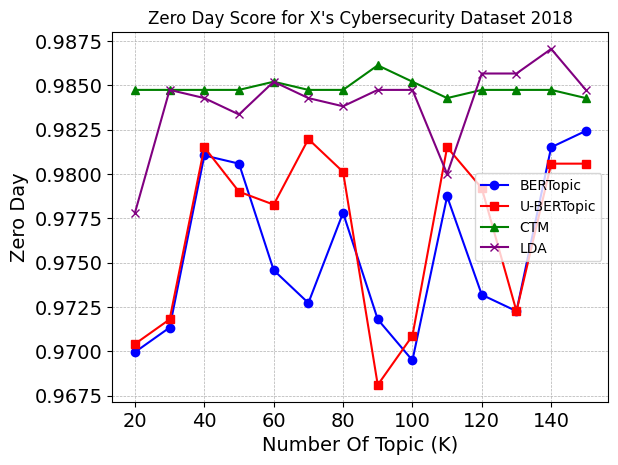

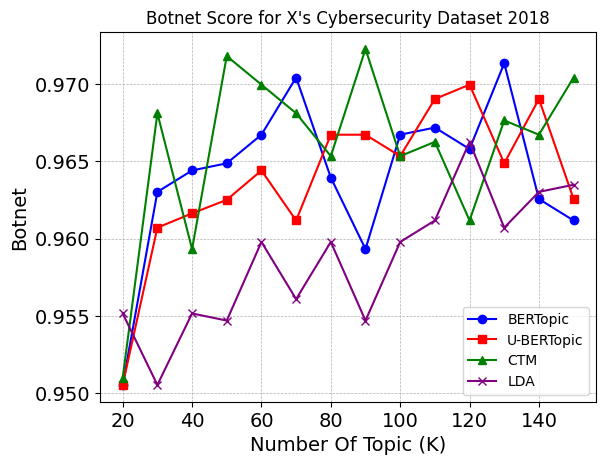

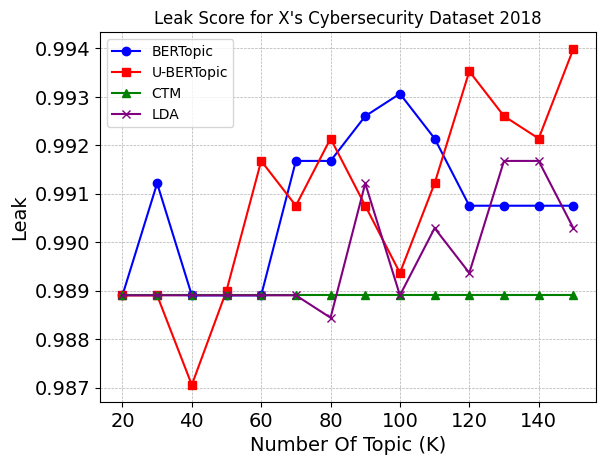

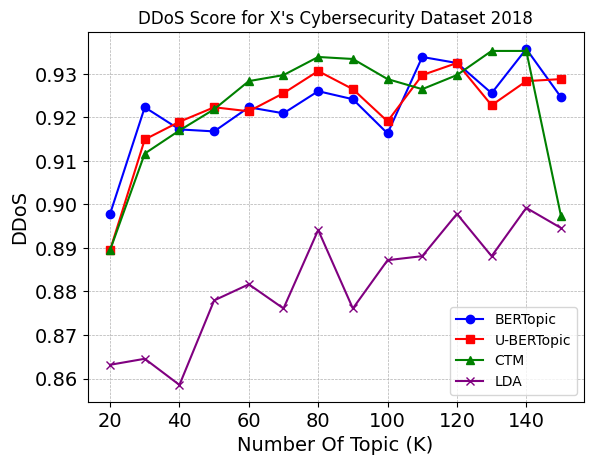

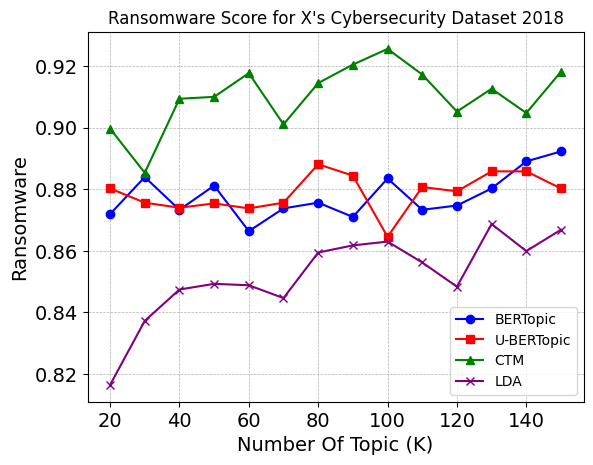

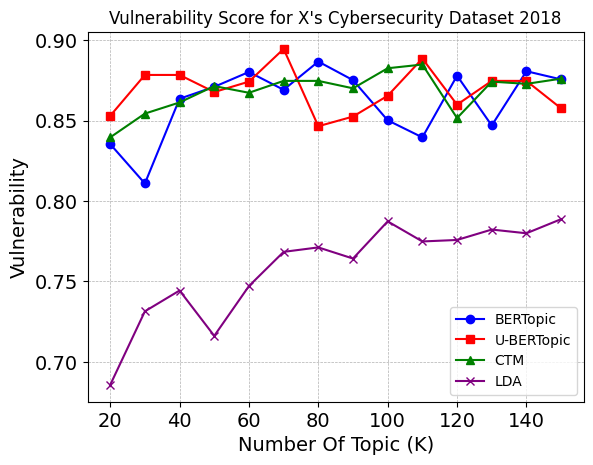

In [29]:
import matplotlib.pyplot as plt
import numpy as np


# X-axis: Number of Topics (K)
K = range(20,160,10)

AttckTypes = ["Zero Day", "Botnet","Leak","DDoS","Ransomware","Vulnerability"]
for i, AttckType in enumerate([ "0day", "botnet","leak","ddos","ransomware","vulnerability"]): #
  Acc_resultsDS2= Acc_resultsDS[Acc_resultsDS['labellingType'] ==AttckType ]


  BERTopic_ds = Acc_resultsDS2[(Acc_resultsDS2["Model"] == "BERTopic")]
  ZTopic_ds = Acc_resultsDS2[(Acc_resultsDS2["Model"] == "UBERTopic")]
  CTM_ds = Acc_resultsDS2[(Acc_resultsDS2["Model"] == "CTM")]
  LDA_ds = Acc_resultsDS2[(Acc_resultsDS2["Model"] == "LDA")]

  # Plotting the lines
  plt.plot(K, BERTopic_ds['Accuracy_ScoreScore'], label='BERTopic', color='blue',marker='o', linestyle='-')
  plt.plot(K, ZTopic_ds['Accuracy_ScoreScore'], label='U-BERTopic', color='red',marker='s', linestyle='-')
  plt.plot(K, CTM_ds['Accuracy_ScoreScore'], label='CTM', color='green',marker='^', linestyle='-')
  plt.plot(K, LDA_ds['Accuracy_ScoreScore'], label='LDA', color='purple',marker='x', linestyle='-')

  # Adding titles and labels
  plt.title( AttckTypes[i] + ' Score for X\'s Cybersecurity Dataset 2018')
  plt.xlabel('Number Of Topic (K)', fontsize=14)
  plt.ylabel(AttckTypes[i],fontsize=14)
  plt.yticks(fontsize=14)
  plt.xticks(fontsize=14)

  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Adding a legend
  plt.legend()

  # Show the plot
  plt.show()